# 1. Импорт данных.

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from pprint import pprint
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

In [36]:
data = pd.read_csv('Admission_Predict.csv')
target_variable = 'Chance of Admit '
data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67


Регрессия, тк значение варьируется от 0 до 1

In [37]:
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


<Axes: >

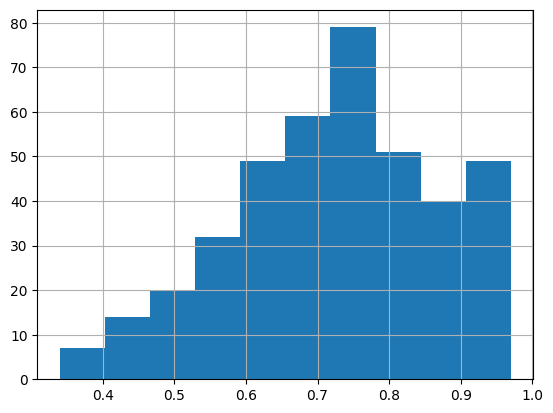

In [38]:
data[target_variable].hist()

In [39]:
data.isnull().sum()

,0
Serial No.,0
GRE Score,0
TOEFL Score,0
University Rating,0
SOP,0
LOR,0
CGPA,0
Research,0
Chance of Admit,0


In [40]:
data[target_variable].describe()

,Chance of Admit
count,400.000000
mean,0.724350
std,0.142609
min,0.340000
25%,0.640000
50%,0.730000
75%,0.830000
max,0.970000


# 3. Предобработка данных

In [41]:
from sklearn.preprocessing import StandardScaler  # Нормирование

y = data[target_variable]
X = data.drop(columns=[target_variable], axis=1)
X = X.drop('Serial No.', axis=1)

X_ans = StandardScaler().fit_transform(X)

In [42]:
X_ans

array([[ 1.76210664,  1.74697064,  0.79882862, ...,  1.16732114,
         1.76481828,  0.90911166],
       [ 0.62765641, -0.06763531,  0.79882862, ...,  1.16732114,
         0.45515126,  0.90911166],
       [-0.07046681, -0.56252785, -0.07660001, ...,  0.05293342,
        -1.00563118,  0.90911166],
       ...,
       [ 1.15124883,  1.41704229,  0.79882862, ...,  1.16732114,
         1.42900622,  0.90911166],
       [-0.41952842, -0.72749202, -0.07660001, ...,  0.61012728,
         0.30403584, -1.09997489],
       [ 1.41304503,  1.58200646,  0.79882862, ...,  0.61012728,
         1.78160888,  0.90911166]])

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X_ans, y, test_size=0.2, random_state=42)

**Оформление данных в виде класса Dataset из библиотеки torch**

In [44]:
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),  #признаки
        torch.tensor(y_test.values, dtype=torch.float32)  #целевая переменная
    ),
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train.values, dtype=torch.float32)
    ),
    batch_size=32,
    shuffle=False
)

Вывод датасетов


In [45]:
for batch, (inputs, targets) in enumerate(train_loader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {inputs.shape}")
    print(f"y shape: {targets.shape}")
    break

Batch: 1
X shape: torch.Size([32, 7])
y shape: torch.Size([32])


**Обучение на тренировочном множестве**

In [46]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(7, 1)

    def forward(self, x):
        return self.fc(x)

class HiddenLayerNN(nn.Module):
    def __init__(self):
        super(HiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(7, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ComplexNN(nn.Module):
    def __init__(self):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(7, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 5)
        self.fc4 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)



def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, epochs=100):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_test_loss = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), targets)
                epoch_test_loss += loss.item()

        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    return train_losses, test_losses

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используется устройство: {device}")


model1 = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01)
train_losses_model1, test_losses_model1 = train_and_evaluate_model(model1, train_loader, test_loader, criterion, optimizer1)

print()

model2 = HiddenLayerNN().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
train_losses_model2, test_losses_model2 = train_and_evaluate_model(model2, train_loader, test_loader, criterion, optimizer2)

print()

model3 = ComplexNN().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)
train_losses_model3, test_losses_model3 = train_and_evaluate_model(model3, train_loader, test_loader, criterion, optimizer3)

Используется устройство: cpu
Epoch 1/100, Train Loss: 0.5192, Test Loss: 0.5547
Epoch 2/100, Train Loss: 0.4986, Test Loss: 0.4887
Epoch 3/100, Train Loss: 0.4157, Test Loss: 0.4358
Epoch 4/100, Train Loss: 0.3849, Test Loss: 0.3908
Epoch 5/100, Train Loss: 0.3595, Test Loss: 0.3502
Epoch 6/100, Train Loss: 0.3111, Test Loss: 0.3212
Epoch 7/100, Train Loss: 0.2931, Test Loss: 0.2898
Epoch 8/100, Train Loss: 0.2546, Test Loss: 0.2664
Epoch 9/100, Train Loss: 0.2434, Test Loss: 0.2433
Epoch 10/100, Train Loss: 0.1985, Test Loss: 0.2267
Epoch 11/100, Train Loss: 0.1935, Test Loss: 0.2105
Epoch 12/100, Train Loss: 0.1875, Test Loss: 0.1940
Epoch 13/100, Train Loss: 0.1636, Test Loss: 0.1810
Epoch 14/100, Train Loss: 0.1498, Test Loss: 0.1691
Epoch 15/100, Train Loss: 0.1447, Test Loss: 0.1588
Epoch 16/100, Train Loss: 0.1227, Test Loss: 0.1508
Epoch 17/100, Train Loss: 0.1202, Test Loss: 0.1411
Epoch 18/100, Train Loss: 0.1103, Test Loss: 0.1339
Epoch 19/100, Train Loss: 0.1120, Test Loss:

Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки matplotlib (выйдет так называемая
learning curve, кривая обучения модели).

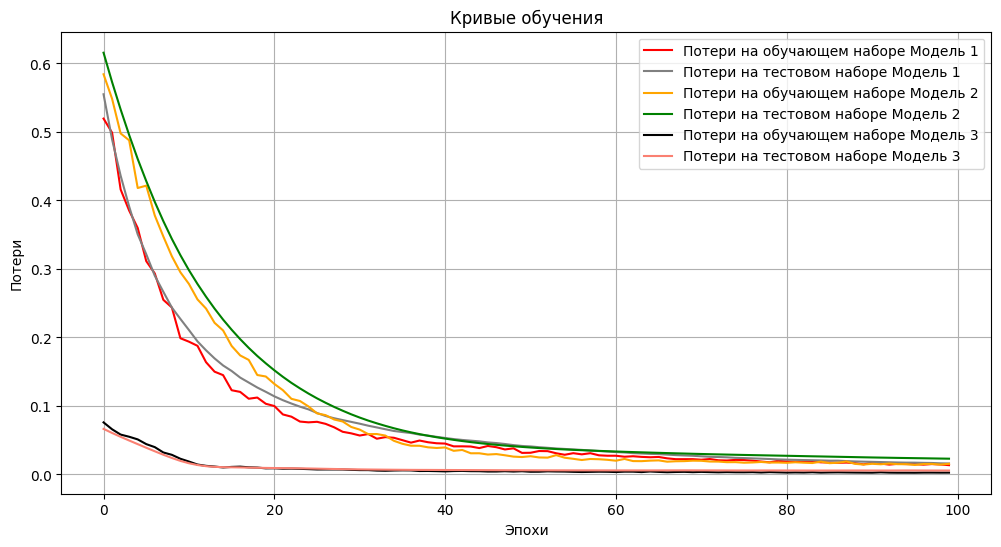

In [47]:
plt.figure(figsize=(12, 6))

plt.plot(train_losses_model1, label='Потери на обучающем наборе Модель 1', color='red')
plt.plot(test_losses_model1, label='Потери на тестовом наборе Модель 1', color='grey')

plt.plot(train_losses_model2, label='Потери на обучающем наборе Модель 2', color='orange')
plt.plot(test_losses_model2, label='Потери на тестовом наборе Модель 2', color='green')

plt.plot(train_losses_model3, label='Потери на обучающем наборе Модель 3', color='black')
plt.plot(test_losses_model3, label='Потери на тестовом наборе Модель 3', color='salmon')

plt.title('Кривые обучения')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid()
plt.show()

**Метрики оценки моделей**

In [48]:

def calculate_mae(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            y_true.extend(targets.numpy())
            y_pred.extend(outputs.flatten())

    return mean_absolute_error(y_true, y_pred)

mae_train_model1 = calculate_mae(model1, train_loader)
mae_test_model1 = calculate_mae(model1, test_loader)

mae_train_model2 = calculate_mae(model2, train_loader)
mae_test_model2 = calculate_mae(model2, test_loader)

mae_train_model3 = calculate_mae(model3, train_loader)
mae_test_model3 = calculate_mae(model3, test_loader)

print(f'MAE на обучающем наборе Модель 1: {mae_train_model1:.4f}, MAE на тестовом наборе Модель 1: {mae_test_model1:.4f}')
print(f'MAE на обучающем наборе Модель 2: {mae_train_model2:.4f}, MAE на тестовом наборе Модель 2: {mae_test_model2:.4f}')
print(f'MAE на обучающем наборе Модель 3: {mae_train_model3:.4f}, MAE на тестовом наборе Модель 3: {mae_test_model3:.4f}')

MAE на обучающем наборе Модель 1: 0.0920, MAE на тестовом наборе Модель 1: 0.0986
MAE на обучающем наборе Модель 2: 0.0951, MAE на тестовом наборе Модель 2: 0.1248
MAE на обучающем наборе Модель 3: 0.0372, MAE на тестовом наборе Модель 3: 0.0568


Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
Какая модель справилась лучше с поставленной задачей?
Имеет ли место переобучение?
Имеет ли место недообучение?
Как можно улучшить метрики моделей?


Какая модель справилась лучше с поставленной задачей?
- Модель 3. Она имеет самую низкую ошибку на обоих наборах данных
0.0372
0.0568

Имеет ли место переобучение?

- Модель 2. имеет большую разницу между ошибкой на обучающем и тестовом наборе:
0.0951
0.1248

Как можно улучшить метрики моделей?
- Можно попробовать уменьшить сложность модели
- Для однослойной модели добавить слои и перейти на Adam в качестве оптимизатора
- Для сложной модели уменьшить переобучение с помощью Dropout